# Custom Named Entity Recognition model with spaCy(clinical named entity recognition)

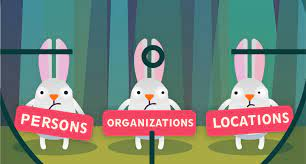

In [4]:
#Import all required libraries
import spacy
import random
import time
import numpy as np
from spacy.util import minibatch, compounding
import sys
from spacy import displacy
from itertools import chain
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

In [5]:
import pandas as pd

  below code is  inpsired from: https://aihub.cloud.google.com/u/0/p/products%2F2290fc65-0041-4c87-a898-0289f59aa8ba

## Convert data in spacy NER formte

In [6]:
def load_data_spacy(file_path):
    file = open(file_path, 'r')
    training_data, entities, sentence, unique_labels = [], [], [], []
    current_annotation = None
    start =0
    end = 0 # initialize counter to keep track of start and end characters
    for line in file:
        line = line.strip("\n").split("\t")
        # lines with len > 1 are words
        if len(line) > 1:
            label = line[1]
            if(label != 'O'):
                label = line[1]+"_Disease"     # the .txt is formatted: label \t word, label[0:2] = label_type
            #label_type = line[0][0] # beginning of annotations - "B", intermediate - "I"
            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)  # length of the word + trailing space
           
            if label == 'I_Disease' :  # if at the end of an annotation
                entities.append(( start,end-1, label))  # append the annotation
                              
            if label == 'B_Disease':                         # if beginning new annotation
                entities.append(( start,end-1, label))# start annotation at beginning of word
                
           
           
            if label != 'O' and label not in unique_labels:
                unique_labels.append(label)
 
        # lines with len == 1 are breaks between sentences
        if len(line) == 1:
            if(len(entities) > 0):
                sentence = " ".join(sentence)
                training_data.append([sentence, {'entities' : entities}])
            # reset the counters and temporary lists
            end = 0 
            start = 0
            entities, sentence = [], []
            
    file.close()
    return training_data, unique_labels

## Train Data

In [7]:
TRAIN_DATA, LABELS = load_data_spacy("train.tsv")
print(TRAIN_DATA)
print("lenth of the TRAIN_DATA :",len(TRAIN_DATA))

[["Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal .", {'entities': [(21, 29, 'B_Disease'), (30, 41, 'I_Disease'), (45, 54, 'B_Disease'), (55, 56, 'I_Disease'), (57, 58, 'I_Disease'), (59, 66, 'I_Disease')]}], ["OBJECTIVES : The United Kingdom Parkinson ' s Disease Research Group ( UKPDRG ) trial found an increased mortality in patients with Parkinson ' s disease ( PD ) randomized to receive 10 mg selegiline per day and L - dopa compared with those taking L - dopa alone .", {'entities': [(32, 41, 'B_Disease'), (42, 43, 'I_Disease'), (44, 45, 'I_Disease'), (46, 53, 'I_Disease'), (132, 141, 'B_Disease'), (142, 143, 'I_Disease'), (144, 145, 'I_Disease'), (146, 153, 'I_Disease'), (156, 158, 'B_Disease')]}], ['Recently , we found that therapy with selegiline and L - dopa was associated with selective systolic orthostatic hypotension which was abolished by withdrawal of selegiline .', {'entities': [(92, 100, 'B_Disea

## Test Data

In [8]:
TEST_DATA, _ = load_data_spacy("test.tsv")
print(TEST_DATA)
print("lenth of the TRAIN_DATA :",len(TEST_DATA))

[['Torsade de pointes ventricular tachycardia during low dose intermittent dobutamine treatment in a patient with dilated cardiomyopathy and congestive heart failure .', {'entities': [(0, 7, 'B_Disease'), (8, 10, 'I_Disease'), (11, 18, 'I_Disease'), (19, 30, 'B_Disease'), (31, 42, 'I_Disease'), (111, 118, 'B_Disease'), (119, 133, 'I_Disease'), (138, 148, 'B_Disease'), (149, 154, 'I_Disease'), (155, 162, 'I_Disease')]}], ['The authors describe the case of a 56 - year - old woman with chronic , severe heart failure secondary to dilated cardiomyopathy and absence of significant ventricular arrhythmias who developed QT prolongation and torsade de pointes ventricular tachycardia during one cycle of intermittent low dose ( 2 . 5 mcg / kg per min ) dobutamine .', {'entities': [(79, 84, 'B_Disease'), (85, 92, 'I_Disease'), (106, 113, 'B_Disease'), (114, 128, 'I_Disease'), (156, 167, 'B_Disease'), (168, 179, 'I_Disease'), (194, 196, 'B_Disease'), (197, 209, 'I_Disease'), (214, 221, 'B_Disease')

In [9]:
VALID_DATA, _ = load_data_spacy("/content/train_dev.tsv")
print(VALID_DATA)
print("lenth of the TRAIN_DATA :",len(VALID_DATA))

[["Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal .", {'entities': [(21, 29, 'B_Disease'), (30, 41, 'I_Disease'), (45, 54, 'B_Disease'), (55, 56, 'I_Disease'), (57, 58, 'I_Disease'), (59, 66, 'I_Disease')]}], ["OBJECTIVES : The United Kingdom Parkinson ' s Disease Research Group ( UKPDRG ) trial found an increased mortality in patients with Parkinson ' s disease ( PD ) randomized to receive 10 mg selegiline per day and L - dopa compared with those taking L - dopa alone .", {'entities': [(32, 41, 'B_Disease'), (42, 43, 'I_Disease'), (44, 45, 'I_Disease'), (46, 53, 'I_Disease'), (132, 141, 'B_Disease'), (142, 143, 'I_Disease'), (144, 145, 'I_Disease'), (146, 153, 'I_Disease'), (156, 158, 'B_Disease')]}], ['Recently , we found that therapy with selegiline and L - dopa was associated with selective systolic orthostatic hypotension which was abolished by withdrawal of selegiline .', {'entities': [(92, 100, 'B_Disea

##Download Spacy Medium corpus

In [10]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051304 sha256=8c22ebb20a2c13da7c3acd00082b8f67e763958f0ecb4d44158b30c2211c645a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bm7b5m2p/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## Load Spacy Medium

In [11]:
import en_core_web_md
nlp = en_core_web_md.load()

## Get ner model from spacy pipeline

In [12]:
if 'ner' not in nlp.pipe_names:
  ner = nlp.create_pipe('ner')
  nlp.add_pipe(ner)
else:
  ner = nlp.get_pipe("ner")

## Add entity labels to the NER pipeline

In [13]:
for i in LABELS:
  ner.add_label(i)

### Disable other pipelines in SpaCy to only train NER

In [14]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

### Define classifications metrics

In [15]:
def calc_precision(pred, true):        
    precision = len([x for x in pred if x in true]) / (len(pred) + 1e-20) # true positives / total pred
    return precision

def calc_recall(pred, true):
    recall = len([x for x in true if x in pred]) / (len(true) + 1e-20)    # true positives / total test
    return recall

def calc_f1(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-20))
    return f1

## defien evaluations function

In [16]:
def evaluate(ner, data ):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))] 
        pred = [i.label_ for i in pred.ents] 
        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))
    return {"textcat_p": np.mean(precisions), "textcat_r": np.mean(recalls), "textcat_f":np.mean(f1s)}

In [17]:
iterations=10
dropout=0.5
display_freq = 1

In [18]:
valid_f1scores=[]
test_f1scores=[]

In [19]:
with nlp.disable_pipes(*other_pipes):
#nlp.vocab.vectors.name = 'spacy_model' # without this, spaCy throws an "unnamed" error
    optimizer = nlp.begin_training()
    for itr in range(iterations):
      random.shuffle(TRAIN_DATA) # shuffle the training data before each iteration
      losses = {}
      batches = minibatch(TRAIN_DATA, size = compounding(16.0, 64.0, 1.5))
      for batch in batches:
        texts, annotations = zip(*batch)
        nlp.update(texts,annotations,drop = dropout,sgd = optimizer,losses = losses)
        scores = evaluate(nlp,VALID_DATA)
      print('=======================================')
      print('Interation = '+str (itr))
      print('Losses = '+str (losses))
      print('===============VALID DATA========================')
            
      print('F1-score = '+str(scores["textcat_f"]))
      print('Precision = '+str(scores["textcat_p"]))
      print('Recall = '+str(scores["textcat_r"]))
      scores = evaluate(nlp,TEST_DATA)
      test_f1scores.append(scores["textcat_f"])
      print('===============TEST DATA========================')
      print('F1-score = '+str(scores["textcat_f"]))
      print('Precision = '+str(scores["textcat_p"]))
      print('Recall = '+str(scores["textcat_r"]))
      print('=======================================')

Interation = 0
Losses = {'ner': 52590.538776397705}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 1
Losses = {'ner': 46975.105504989624}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 2
Losses = {'ner': 46992.34825515747}
===============VALID DATA========================
F1-score = 0.051324055061840075
Precision = 0.041738370207425574
Recall = 0.07296416938110749
===============TEST DATA========================
F1-score = 0.04375026470667812
Precision = 0.03587319905053895
Recall = 0.06192821956368754
Interation = 3
Losses = {'ner': 47732.297996520996}
===============VALID DATA========================
F1-score = 0.5907367802940711
Precision = 0.5620224646125203
Recall = 0.666980766247

In [25]:
nlp.to_disk("spacy_example")

In [26]:
def load_model(model_path):
    ''' Loads a pre-trained model for prediction on new test sentences
   
    model_path : directory of model saved by spacy.to_disk
    '''
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    ner = nlp.from_disk(model_path)
    return ner

In [27]:
ner = load_model("spacy_example")



test_sentences = [x[0] for x in TEST_DATA[0:40]] # extract the sentences from [sentence, entity]
for x in test_sentences:
    doc = ner(x)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc,jupyter=True, style = "ent")

pointes 11 18 B_Disease
ventricular 19 30 I_Disease
tachycardia 31 42 I_Disease
dilated 111 118 B_Disease
cardiomyopathy 119 133 I_Disease
congestive 138 148 B_Disease
heart 149 154 I_Disease
failure 155 162 I_Disease


heart 79 84 B_Disease
failure 85 92 I_Disease
dilated 106 113 B_Disease
cardiomyopathy 114 128 I_Disease
ventricular 156 167 B_Disease
arrhythmias 168 179 I_Disease
pointes 225 232 B_Disease
ventricular 233 244 I_Disease
tachycardia 245 256 I_Disease


pointes 26 33 B_Disease
ventricular 34 45 I_Disease
tachycardia 46 57 I_Disease
fatal 132 137 B_Disease
arrhythmias 138 149 I_Disease
disturbances 234 246 B_Disease


dyspnea 109 116 B_Disease
loss 119 123 B_Disease
consciousness 127 140 B_Disease
papular 163 170 B_Disease
rash 171 175 I_Disease
pain 268 272 B_Disease


allergy 94 101 B_Disease


hyperammonemic 18 32 B_Disease
encephalopathy 33 47 I_Disease
cancer 51 57 B_Disease
dehydration 145 156 B_Disease
infection 161 170 B_Disease


cancer 23 29 B_Disease
hyperammonemic 72 86 B_Disease
encephalopathy 87 101 I_Disease


decompensated 25 38 B_Disease
liver 39 44 I_Disease
disease 45 52 I_Disease


hyperammonemic 9 23 B_Disease
encephalopathy 24 38 I_Disease


azotemia 59 67 B_Disease
bacterial 98 107 B_Disease
infections 108 118 I_Disease
infection 143 152 B_Disease
dehydration 180 191 B_Disease


hyperammonemia 54 68 B_Disease


hyperammonemic 16 30 B_Disease
encephalopathy 31 45 I_Disease


Azotemia 0 8 B_Disease
fluid 16 21 B_Disease
insufficiency 22 35 I_Disease
bacterial 40 49 B_Disease


hypoactivity 138 150 B_Disease
hyperactivity 228 241 B_Disease


hypoactivity 137 149 B_Disease
hyperactivity 177 190 B_Disease


memory 56 62 B_Disease
impairment 63 73 I_Disease


hyperalgesia 136 148 B_Disease


impairment 109 119 B_Disease
memory 136 142 B_Disease


liver 20 25 B_Disease
toxicity 26 34 I_Disease


rheumatoid 44 54 B_Disease
arthritis 55 64 I_Disease
cytolytic 85 94 B_Disease
hepatitis 95 104 I_Disease


acute 4 9 B_Disease
cytolytic 10 19 I_Disease
hepatitis 20 29 I_Disease
hypersensitivity 157 173 B_Disease


liver 37 42 B_Disease
toxicity 43 51 I_Disease
hepatic 102 109 B_Disease
damage 110 116 I_Disease


HL60 53 57 B_Disease
CD34 62 66 B_Disease
marrow 89 95 I_Disease
aplastic 160 168 B_Disease
anemia 169 175 I_Disease


antipsychotic 4 17 B_Disease
aplastic 182 190 B_Disease
anemia 191 197 I_Disease


necrosis 3 11 B_Disease
necrosis 155 163 B_Disease


aplastic 51 59 B_Disease
anemia 60 66 I_Disease
aplastic 242 250 B_Disease
anemia 251 257 I_Disease


catalepsy 31 40 B_Disease
atypical 79 87 B_Disease
antipsychotic 88 101 I_Disease
nature 102 108 I_Disease


catalepsy 84 93 B_Disease


catalepsy 112 121 B_Disease


Neuroleptic 0 11 B_Disease
catalepsy 84 93 B_Disease


catalepsy 99 108 B_Disease


Catalepsy 0 9 B_Disease


catalepsy 110 119 B_Disease


ventricular 15 26 B_Disease
dysfunction 27 38 I_Disease
coronary 63 71 B_Disease
artery 72 78 I_Disease
disease 79 86 I_Disease
myocardial 130 140 B_Disease
ischaemia 141 150 I_Disease


ventricular 95 106 B_Disease
dysfunction 107 118 I_Disease
coronary 136 144 B_Disease
artery 145 151 I_Disease
disease 152 159 I_Disease


ventricular 86 97 B_Disease
ischaemia 145 154 B_Disease


angina 35 41 B_Disease
coronary 68 76 B_Disease
artery 77 83 I_Disease
disease 84 91 I_Disease
ventricular 110 121 B_Disease


ST 72 74 B_Disease
depression 75 85 I_Disease


coronary 31 39 B_Disease
artery 40 46 I_Disease
disease 47 54 I_Disease
ischaemia 76 85 B_Disease
ventricular 123 134 B_Disease
dysfunction 135 146 I_Disease
myocardial 164 174 B_Disease


ischaemia 19 28 B_Disease
coronary 126 134 B_Disease
artery 135 141 I_Disease
disease 142 149 I_Disease


In [28]:
ner = load_model("spacy_example")
doc = ner("Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal.The aims of this study were to confirm our previous findings in a separate cohort of patients and to determine the time course of the cardiovascular consequences of stopping selegiline in the expectation that this might shed light on the mechanisms by which the drug causes orthostatic hypotension")
displacy.render(doc,jupyter=True, style = "ent")